<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/16_NLP_multi_conv_non_sequential_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependencies and Set Hyperparameters


In [0]:
# Import dependencies
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [0]:
architecture = '''
Architecture diagram

              ----------        -------------------       ----------       --------								
             |           | --> | conv (kernel - 2) | --> | max_pool | --> | 	     | 
             |           |      -------------------       ----------      |        |	
             |           |                                                |	       |
 ------      |           |      -------------------       ----------      |        |	    --------       --------	      ----		
| text | --> | Embedding | --> | conv (kernel - 3) | --> | max_pool | --> | concat | --> | dense1 | --> | dense2 | --> | o/p | 
 ------      |           |       ------------------       ----------      |        |	    --------       --------	      ----
             |           |                                                |        | 
             |           |      -------------------       ----------      |        |								
             |           | --> | conv (kernel - 4) | --> | max_pool | --> | 	     | 
             |           |      -------------------       ----------      |        |	
              -----------                                                  --------

'''

In [0]:
# Set hyperparameters
# output directory name:
output_dir = 'model_output/multiCNN'

# training:
epochs = 4 
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 5000 
max_review_length = 400 # due to usage of CNN and maxpooling.
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# CNN layer architecture:
# Created as a list for use in loop
n_conv = [256,256,256]
n_kernel = [2, 3, 4]

# Dense layer architecture:
n_dense = 256
drop_dense = 0.2



# Load and Pre-Process Data

In [0]:
# Load data
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [0]:
# Preprocess data
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

# Neural Network Section

In [0]:
# Design Neural Network
# Start with input layer
input_layer = Input(shape=(max_review_length,), dtype='int16', name='input' )

# Add first hidden layer - embedding
embed_layer = Embedding(input_dim=n_unique_words, output_dim= n_dim, input_length= max_review_length, 
                            name = 'embedding') (input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name = 'drop_embed') (embed_layer)

# Add three parallel CNN layers:
conv = []
maxp = []
for i in range(3):
 conv.append(Conv1D(filters=n_conv[i], kernel_size=n_kernel[i], activation='relu', 
                    name = f'conv_{i+1}') (drop_embed_layer))
 maxp.append(GlobalMaxPooling1D(name = f'maxp_{i+1}' ) (conv[i]))

# Add concatenate layer to concatenate o/p from three activation layers
concat = concatenate(maxp) # Usually fed as a list

# Add two dense layers
dense_layer = Dense(n_dense, 
                    activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(drop_dense, name='drop_dense')(dense_layer)

dense_2 = Dense(int(n_dense/4), 
                activation='relu', name='dense_2')(drop_dense_layer)
dropout_2 = Dropout(drop_dense, name='drop_dense_2')(dense_2)


# Add o/p layer
output_layer = Dense(1, activation = 'sigmoid', name = 'output') (dropout_2)

# Create model
model = Model(input_layer, output_layer)

In [8]:
# Review model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 399, 256)     33024       drop_embed[0][0]                 
______________________________________________________________________________________________

In [0]:
# Configure model
model.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [0]:
# Create model checkpoints
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [11]:
# Train model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 21s 106ms/step - loss: 0.4953 - accuracy: 0.7283 - val_loss: 0.3170 - val_accuracy: 0.8639
Epoch 2/4
196/196 [==============================] - 20s 104ms/step - loss: 0.2649 - accuracy: 0.8943 - val_loss: 0.2814 - val_accuracy: 0.8820
Epoch 3/4
196/196 [==============================] - 20s 103ms/step - loss: 0.1939 - accuracy: 0.9272 - val_loss: 0.2606 - val_accuracy: 0.8944
Epoch 4/4
196/196 [==============================] - 20s 103ms/step - loss: 0.1399 - accuracy: 0.9498 - val_loss: 0.2882 - val_accuracy: 0.8930


# Evaluate

In [0]:
# Load model with highest accuracy
model.load_weights(output_dir+"/weights.03.hdf5")

In [0]:
# Make predictions using best model
y_hat = model.predict(x_valid)

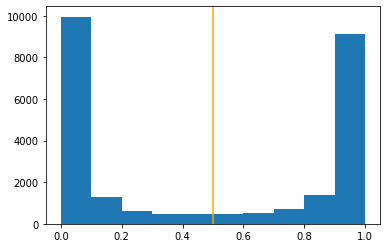

In [14]:
# Plot predictions
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [15]:
# Find AUC-ROC value
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
print("AUC-ROC Value: {:0.2f}".format(pct_auc))

AUC-ROC Value: 96.14


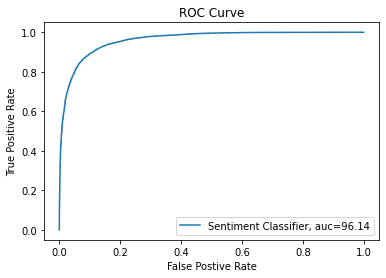

In [16]:
fpr, tpr, auc = roc_curve(y_valid,  y_hat)
plt.plot(fpr,tpr,label="Sentiment Classifier, auc="+"{:0.2f}".format(pct_auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [0]:
# Non seq Conv NN gave highest ROC score than all other NLP architecture evaluated so far.
# Note all this applies to specific train/test set and not an over arching generalization